# Pre-Process Decagon Data and Save Using Pickle

## Highlight



The frequency distribution of DD edge types is shown in the following figure. In Zinik(2018)'s work, they remove the DD edge types that each occurred in less than 500 drug combinations. Therefore, they use the sub-dataset of what we described and analyzed in this notebook.
![](hist_dd_edge.png)

Here is the summary of the data they use:
- protein: 19k
- protein edge: 1431k
- drug: 645
- drug edge: 6966k
- drug edge type: 963
- drug with protein link (dwp): 284
- dwp edge: 1810k
- drug feature: dim 10k, {0, 1} binary valued


## 1. Analysis Nodes, Edges, Node Features and Edge Types

In [1]:
import csv


In [2]:
# set data paths
pp_f = "raw_data/bio-decagon-ppi.csv"
dd_f = "raw_data/bio-decagon-combo.csv"
dp_f = "raw_data/bio-decagon-targets.csv"
ds_f = "raw_data/bio-decagon-mono.csv"


In [3]:
# original data collection holder
p_set = set()                 # protein nodes
d_set = set()                 # drug nodes
combo_set = set()             # edge types
mono_set = set()              # additional drug features

# read file to list
pp_list, ddt_list, dp_list, ds_list = [], [], [], []   # lists of tuples

# set temporary variable
a, b, c = 0, 0, 0

### 1.1 protein-protein association network

Includes:

- physical interaction
- functional associations

Notation:

- node: protein
- edge: association or interaction

Number:

- 19081 nodes (min: 1; max: 110255169)
- 715612 edges

In [4]:
with open(pp_f, 'r') as f:
    ppi = csv.reader(f)
    next(ppi)
    for [g1, g2] in ppi:
        a, b = int(g1), int(g2)
        p_set.add(a)
        p_set.add(b)
        pp_list.append((a, b))
print("{:d} protein nodes indexed from {:d} to {:d}.".format(len(p_set), min(p_set), max(p_set)))
print("{:d} protein-protein edges".format(len(pp_list)))

19081 protein nodes indexed from 1 to 110255169.
715612 protein-protein edges


### 1.2 drug-drug association network with side effects

!! TIME COSTY SECTION

Notation:

- node: drug
- edge with typies: type of side effects that are associated with drug pairs

Number:

- 645 nodes
- 63473 edges
- 1317 edge types

In [6]:
with open("raw_data/bio-decagon-combo.csv", "r") as f:
    ppi = csv.reader(f)
    next(ppi)
    for [d1, d2, t, n] in ppi:
        a, b, c = int(t.split('C')[-1]), int(d1.split('D')[-1]), int(d2.split('D')[-1])
        combo_set.add(a)
        d_set.add(b)
        d_set.add(c)
        ddt_list.append((b, c, a))
print("{:d} drug nodes indexed from {:d} to {:d}".format(len(d_set), min(d_set), max(d_set)))
print("{:d} drug-drug edges with {:d} edge types indexed from {:d} to {:d}"
      .format(len(ddt_list), len(combo_set), min(combo_set), max(combo_set)))


645 drug nodes indexed from 85 to 9571074
9298882 drug-drug edges with 1317 edge types indexed from 731 to 1621958


### 1.3 drug-protein association network

Notation:

- node: drug and genes(encode protein)
- edge: gene is targeted by drug

Number:

- 3932 nodes: 284 drug; 3648 gene
- 18690 edges

In [6]:
p_temp_set = set()
d_temp_set = set()

with open("raw_data/bio-decagon-targets.csv", "r") as f:
    ppi = csv.reader(f)
    next(ppi)
    for [d, p] in ppi:
        a, b = int(d.split('D')[-1]), int(p)
        d_set.add(a)
        d_temp_set.add(a)
        p_set.add(b)
        p_temp_set.add(b)
        dp_list.append((a, b))
print("{:d} drug-protein edges".format(len(dp_list)))
print("{:d} proteins not in the ppi network".format(p_set.__len__() - 19081))
print("Protein numbers of {:d} indexed from {:d} to {:d}".format(len(p_temp_set), min(p_temp_set), max(p_temp_set)))
print("Drug numbers of {:d} indexed from {:d} to {:d}".format(len(d_temp_set), min(d_temp_set), max(d_temp_set)))

print("{:d} drugs not in the drug-drug network".format(d_set.__len__() - 645))


18690 drug-protein edges
8 proteins not in the ppi network
Protein numbers of 3648 indexed from 9 to 101060200
Drug numbers of 284 indexed from 119 to 6436173
0 drugs not in the drug-drug network


### 1.4 single drug side effects

Notation:

- node: drug and side-effect
- edge: side effect caused by drug

Number:

- 10825 nodes: 640 drug; 10184 side effect
- 174978 edges

In [7]:
temp = d_set.__len__()
s_temp_set = set()
d_temp_set = set()
ds_list = []

with open("raw_data/bio-decagon-mono.csv", "r") as f:
    ppi = csv.reader(f)
    next(ppi)
    for [d, e, n] in ppi:
        a, b = int(e.split('C')[-1]), int(d.split('D')[-1])
        mono_set.add(a)
        d_set.add(b)
        s_temp_set.add(a)
        d_temp_set.add(b)
        ds_list.append((b, a))
print("{:d} drugs not in the drug-drug network."
      .format(d_set.__len__() - temp))
print("{:d} single drug side effects in drug pair side effects set."
      .format((combo_set & mono_set).__len__()))

print("Drug: {:d} indexed from {:d} to {:d}"
      .format(len(d_temp_set), min(d_temp_set), max(d_temp_set)))
print("Side effect: {:d} indexed from {:d} to {:d}"
      .format(len(s_temp_set), min(s_temp_set), max(s_temp_set)))
print("Edge: {:d}".format(len(ds_list)))

0 drugs not in the drug-drug network.
0 single drug side effects in drug pair side effects set.
Drug: 639 indexed from 85 to 9571074
Side effect: 10184 indexed from 727 to 3665888
Edge: 174977


In [8]:
# the numbers
num_gene = p_set.__len__()
num_drug = d_set.__len__()
num_edge_type = combo_set.__len__()
num_drug_additional_feature = mono_set.__len__()

print("Summary: ")
print(" -> Protein Node              : {:d}".format(num_gene))
print(" -> Drug    Node              : {:d}".format(num_drug))
print(" -> Drug    Pair  Side  Effect: {:d}".format(num_edge_type))
print(" -> Single  Drug  Side  Effect: {:d}".format(num_drug_additional_feature))

Summary: 
 -> Protein Node              : 19089
 -> Drug    Node              : 645
 -> Drug    Pair  Side  Effect: 1317
 -> Single  Drug  Side  Effect: 10184


## 2. Index Drug Nodes, Protein Nodes, Drug Additional Features and Drug-Drug Edge Types

Note: Using gene presents its encode protein

In [9]:
import scipy.sparse as sp

### 2.1 Re-indexing Stragy

xxx\_to\_new is a one-row sparse matrix:

- index: real drug/protein/side effect index  
- value: its new index 

xxx\_to\_old is a list:

- index: the re-allocated index
- value: original index


In [10]:
# protein
gene_to_old = list(p_set)
gene_to_new = sp.csr_matrix((range(num_gene), ([0] * num_gene, gene_to_old)))

# drug
drug_to_old = list(d_set)
drug_to_new = sp.csr_matrix((range(num_drug), ([0] * num_drug, drug_to_old)))

# drug pair side effect
edge_type_to_old = list(combo_set)
edge_type_to_new = sp.csr_matrix((range(num_edge_type), ([0] * num_edge_type, edge_type_to_old)))

# single drug side effect
side_effect_to_old = list(mono_set)
side_effect_to_new = sp.csr_matrix((range(num_drug_additional_feature), ([0] * num_drug_additional_feature, side_effect_to_old)))


### 2.2 report the top 10 best and worst performance side effects

In [ ]:
# side effect name - original index
best_name = ["Mumps", "Carbuncle", "Coccydynia", "Tympanic membrane perfor", "Dyshidrosis", 
             "Spondylosis", "Schizoaffective disorder", "Breast dysplasia", "Ganglion", "Uterine polyp"
            ]
worst_name = ["Bleeding", "Body temperature increased",  "Emesis", "Renal disorder", "Leucopenia", 
              "Diarrhea", "Icterus", "Nausea", "Itch", "Anaemia"]
best_org_ind = [26780, 7078, 9193, 206504, 32633, 
                38019, 36337, 16034, 1258666, 156369] 
worst_org_ind = [19080, 15967, 42963, 22658, 23530, 
                 11991, 22346, 27497, 33774, 2871]

best_ind = [edge_type_to_new[0, i] for i in best_org_ind]
worst_ind = [edge_type_to_new[0, i] for i in worst_org_ind]

print(best_ind, worst_ind)


In [ ]:
edge_type_to_new[0, 26780]

## 3. Construct Sparse Adjacency Matrix

### 3.1 gene-gene adjacency matrix



In [12]:
import numpy as np

In [13]:
# set temporary variable
r, c, array_length = [], [], len(pp_list)

In [14]:
for i in range(array_length):
    r.append(gene_to_new[0, pp_list[i][0]])
    c.append(gene_to_new[0, pp_list[i][1]])
    
gene_adj = sp.csr_matrix(([1] * array_length, (r, c)), shape=(num_gene, num_gene))

gene_degrees = np.array(gene_adj.sum(axis=0)).squeeze()


### 3.2 drug-gene & gene-drug adjacency matrix


In [17]:
# set temporary variable
r, c, array_length = [], [], len(dp_list)

In [18]:
for i in range(array_length):
    r.append(drug_to_new[0, dp_list[i][0]])
    c.append(gene_to_new[0, dp_list[i][1]])

drug_gene_adj = sp.csr_matrix(([1] * array_length, (r, c)), shape=(num_drug, num_gene))
gene_drug_adj = drug_gene_adj.transpose(copy=True)
    

### 3.3 drug-drug adjacency matrix list 

Note: this list is indexed by drug-drug edge type index

!! TIME COSTY SECTION

In [19]:
# set temporary variable
# r: key is the index of edge type, value is a list of two lists [drug list, drug list]
r = {}        
array_length = len(ddt_list)


In [20]:
# build drug-drug network by edge types
for i in range(array_length):
    c = edge_type_to_new[0, ddt_list[i][2]]
    if c not in r:
        r[c] = [drug_to_new[0, ddt_list[i][0]]], [drug_to_new[0, ddt_list[i][1]]]
    else:
        r[c][0].append(drug_to_new[0, ddt_list[i][0]])
        r[c][1].append(drug_to_new[0, ddt_list[i][1]])

# build adjacency matrix
drug_drug_adj_list = []
for i in range(num_edge_type):
    drug_drug_adj_list.append(sp.csr_matrix(([1] * len(r[i][0]), (r[i][0], r[i][1])), shape=(num_drug, num_drug)))

drug_degrees_list = [np.array(drug_adj.sum(axis=0)).squeeze() for drug_adj in drug_drug_adj_list]

                

In [21]:
drug_drug_adj_list = []

for i in range(num_edge_type):
    drug_drug_adj_list.append(sp.load_npz("".join(["data_decagon/drug-sparse-adj/type_", str(i), ".npz"])))
    

## 4. Generate Feature Vector

### 4.1 gene one-hot vector

In [22]:
from data.utils import sparse_to_tuple

In [23]:
gene_feat = sp.identity(num_gene)

gene_nonzero_feat, gene_num_feat = gene_feat.shape
gene_feat = sparse_to_tuple(gene_feat.tocoo())

### 4.2 drug feature vector with additional feature

In [24]:
# index feature
r, c = list(range(num_drug)), list(range(num_drug))

# additional feature append to index feature
for (a, b) in ds_list:
    r.append(drug_to_new[0, a])
    c.append(side_effect_to_new[0, b] + num_drug)

array_length = num_drug + len(ds_list)
drug_feat_sparse = sp.csr_matrix(([1] * array_length, (r, c)), shape=(num_drug, num_drug + num_drug_additional_feature))

drug_nonzero_feat, drug_num_feat = drug_feat_sparse.shape[1], np.count_nonzero(drug_feat_sparse.sum(axis=0))
drug_feat = sparse_to_tuple(drug_feat_sparse.tocoo())


### 4.3 Visualization of side effects

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


In [26]:
# dimension reduction
drug_embedded = TSNE(n_components=2).fit_transform(drug_feat_sparse.toarray())


In [27]:
# random selecting five side effects for visualization
np.random.seed(19680801)
num_show_edge_index = 4
num_show_edge = 60

selected_edge_types = np.random.choice(num_edge_type, num_show_edge_index, replace=False)
selected_edge_types.tolist()

[1172, 702, 793, 94]

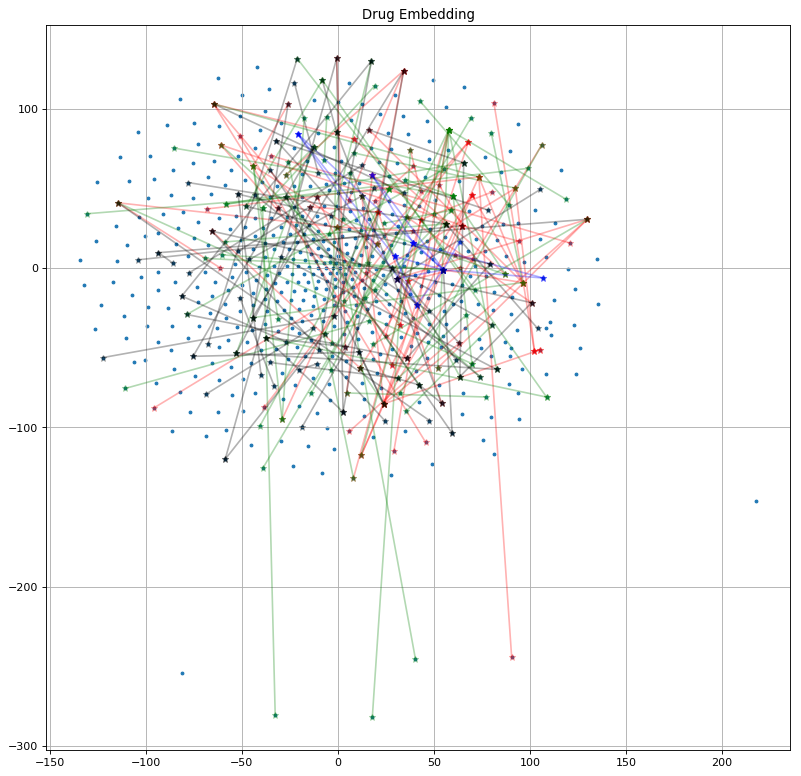

In [28]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
title = "Drug Embedding Before Training"
col = ['r', 'g', 'b', 'k', 'c', 'm', 'y']

plt.scatter(drug_embedded[:, 0], drug_embedded[:, 1], s=6, label='drug')
for i in range(num_show_edge_index):
    edge = selected_edge_types[i]
    r, c = drug_drug_adj_list[edge].nonzero()
    
    if len(r) > num_show_edge:
        selected_drug_pair_index = np.random.choice(len(r), num_show_edge, replace=False).tolist()
    else:
        selected_drug_pair_index = list(range(len(r)))
        
    for j in selected_drug_pair_index:
        [x1, y1] = drug_embedded[r[j], :]
        [x2, y2] = drug_embedded[c[j], :]
        
        plt.plot([x1, x2], [y1, y2], color=col[i], alpha=0.3, marker='*')
    

# setting
plt.title(title)
plt.grid()
plt.savefig("Drug Embedding before training.pdf")
plt.show()

## 5. Save to Files

### 5.1 save graph infomation

In [11]:
import pickle


In [16]:
# index saver
with open('./data_decagon/edge_type_to_old.pkl', 'wb') as f:
    pickle.dump(edge_type_to_old, f)
with open('./data_decagon/drug_to_old', 'wb') as f:
    pickle.dump(drug_to_old, f)


In [13]:
with open('data_decagon/graph_num_info.pkl', 'wb') as f:
    pickle.dump([num_gene, num_drug, num_edge_type, num_drug_additional_feature], f)



### 5.2 save sparse matrix

In [ ]:
# gene-gene adj
sp.save_npz("data_decagon/gene-sparse-adj.npz", gene_adj)

# gene-drug adj
sp.save_npz("data_decagon/drug-gene-sparse-adj.npz", drug_gene_adj)
sp.save_npz("data_decagon/gene-drug-sparse-adj.npz", gene_drug_adj)

# drug-drug adj
for i in range(num_edge_type):
    sp.save_npz("".join(["data_decagon/drug-sparse-adj/type_", str(i), ".npz"]), drug_drug_adj_list[i])
    

### 5.3 save drug sparse feature vectors

In [29]:
# drug feature vector
sp.save_npz("data_decagon/drug-feature-sparse.npz", drug_feat_sparse)
